# **Modelling and Evaluation Notebook**

## Objectives
Answer Business requirement 2: Binary Classification using Convolutional Neural Networks

* predict if a given leaf is infected or not judging by the presence of powdery mildew.
* use the CNN to map relationships between features and labels.
* build a binary classifier and generate reports.

## Inputs

* inputs/cherry-leaves-dataset/cherry-leaves/train
* inputs/cherry-leaves-dataset/cherry-leaves/test
* inputs/cherry-leaves-dataset/cherry-leaves/validation
* image_shape.pkl (image shape embeddings pickle file)

## Outputs

* cherry-tree-model.h5 (model)
* class_distribution.png
* class_indices.pkl
* model_training_acc.png
* model_training_losses.png
* test-evaluation.pkl
* train-evaluation.pkl
* val-evaluation.pkl




---

### Define model version
* v6 is current per Nov 2024

In [1]:
version = 'v6'

### Import regular packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Change working directory

Change the working directory from current folder to parent folder for root access

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-ML/jupyter_notebooks'

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-ML'

### Set input directory

In [6]:
my_data_dir = 'inputs/cherry-leaves-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [7]:

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available, create a new version.


### Gather labels

In [8]:
try:
    labels = os.listdir(train_path)
except:
    labels = ['healthy', 'powdery_mildew']

print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Load image shape embeddings

In [9]:
import joblib

try:
    # Import saved image shape embedding pickle file
    image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")

except:
    # for google collab
    image_shape = (256, 256, 3)

finally:
    print(image_shape)



(256, 256, 3)


***

# Review class distribution

* across whole dataset
* per train, test, and validation

* train- healthy: 1472 images

* train- powdery_mildew: 1472 images

* validation- healthy: 210 images

* validation- powdery_mildew: 210 images

* test- healthy: 422 images

* test- powdery_mildew: 422 images

4208 images total
--------


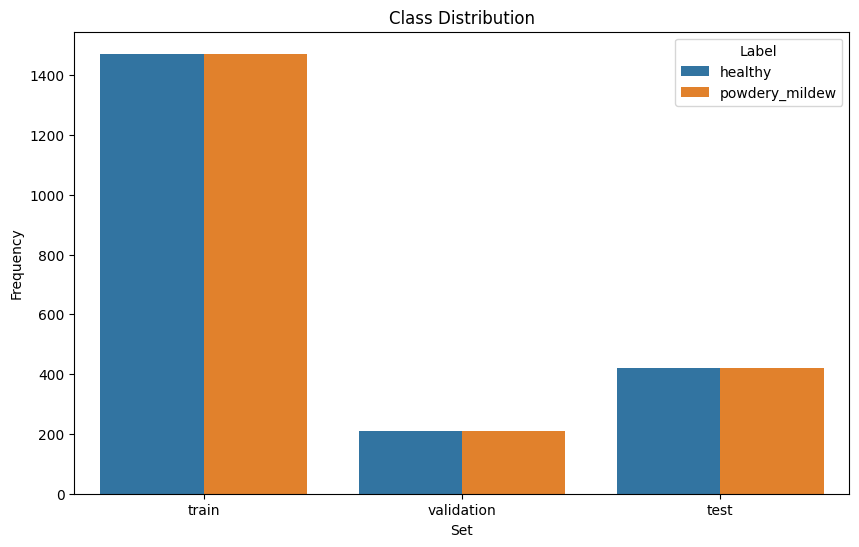



--------
                Frequency         Set  Percent of DataSet
Label                                                    
healthy            1472.0       train                35.0
powdery_mildew     1472.0       train                35.0
healthy             210.0  validation                 5.0
powdery_mildew      210.0  validation                 5.0
healthy             422.0        test                10.0
powdery_mildew      422.0        test                10.0


In [10]:
df_freq = pd.DataFrame([])
total_images_count = 0

# gather info
for folder in ['train', 'validation', 'test']:
    for label in labels:

        path = my_data_dir + '/' + folder + '/' + label
        
        image_count = int(len(os.listdir(path)))
        total_images_count += image_count

        try:
            df_freq = df_freq.append(pd.Series({'Set': folder,'Label': label,'Frequency': image_count}), ignore_index=True )
            print(f"* {folder}- {label}: {image_count} images\n")
        except:
            # for google collab functionality 
            df_freq = df_freq.concat(pd.Series({'Set': folder,'Label': label,'Frequency': image_count}), ignore_index=True )
            print(f"* {folder}- {label}: {image_count} images\n")


print(f'{total_images_count} images total')
print('--------')

### plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Set', y='Frequency', hue='Label', data=df_freq)
plt.title('Class Distribution')
plt.savefig(f'{file_path}/class_distribution.png', bbox_inches='tight', dpi=600)
plt.show()
print('\n')

print('--------')

# confirm percentages of dataset
df_freq.set_index('Label', inplace=True)
df_freq['Percent of DataSet'] = round(df_freq['Frequency'] / total_images_count * 100)

print(df_freq)


We can confirm that train, validation and test set percentages of dataset are split as expected, and that there are equal amounts of both classes (healthy and powdery_mildew) in each set.

***

# Image Augmentation

### Define image data generator, initialize


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1,
                                        #   brightness_range=[0.8, 1.2],
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

2024-11-01 13:18:34.265941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-01 13:18:34.265976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Define batch size 

In [12]:
batch_size = 20

### Augment TRAINING image dataset


In [13]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True,
                                                     # seed=42, TODO
                                                     )


train_set.class_indices


train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale validation image dataset


In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Rescale test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(20, 256, 256, 3)

--------------


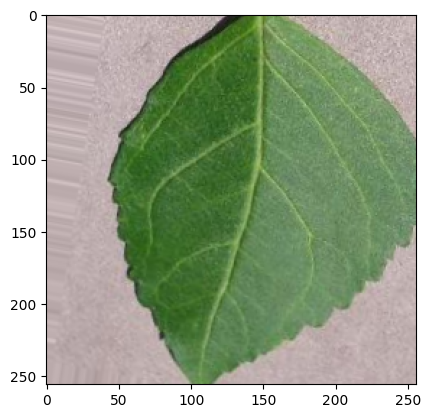

(20, 256, 256, 3)

--------------


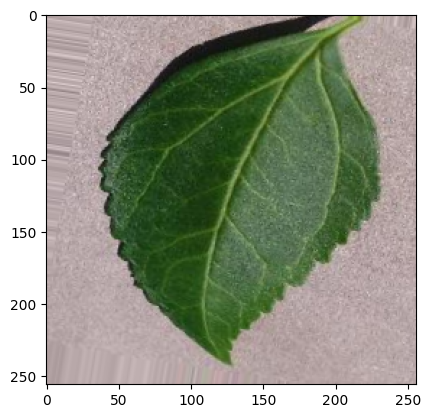

(20, 256, 256, 3)

--------------


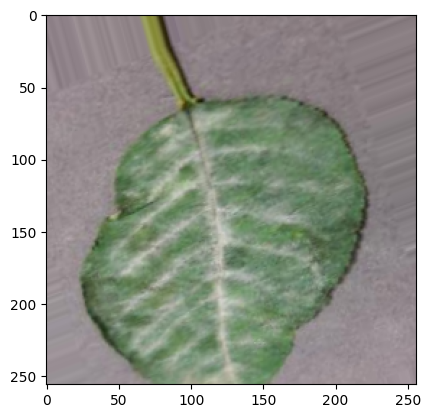

In [16]:
for _ in range(3):
    try:
        img, label = train_set.next()
    except:
        # for google collab functionality
        img, label = next(train_set)

    print(f'{img.shape}\n')  # expect: (20, 256, 256, 3)
    plt.imshow(img[0])
    print('--------------')
    plt.show()


### Plot augmented validation and test images

(20, 256, 256, 3)

--------------


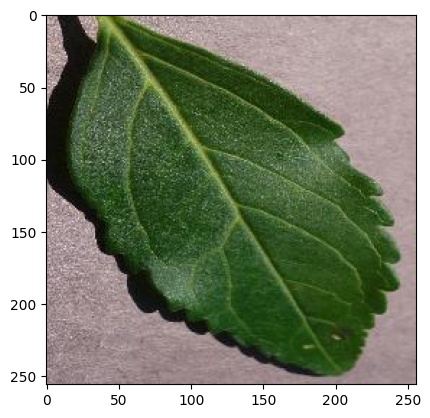

(20, 256, 256, 3)

--------------


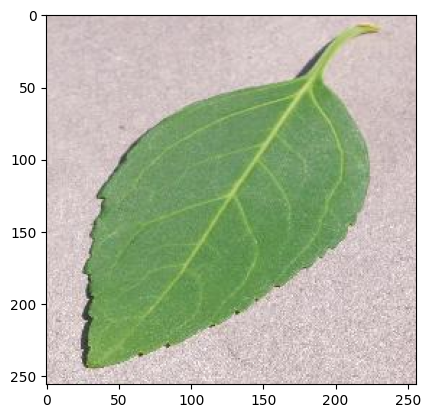

(20, 256, 256, 3)

--------------


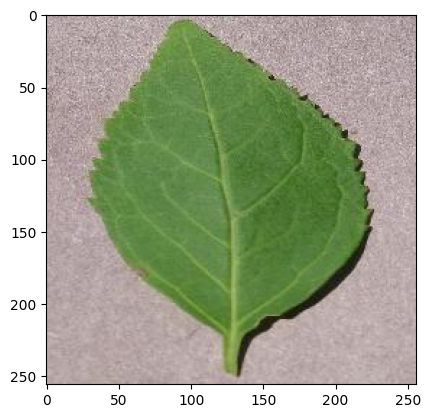

In [17]:
# validation_set
for _ in range(3):
    try:
        img, label = validation_set.next()
    except:
        # for google collab functionality
        img, label = next(validation_set)
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()



(20, 256, 256, 3)

--------------


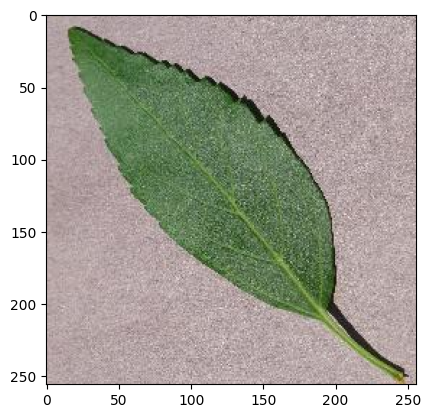

(20, 256, 256, 3)

--------------


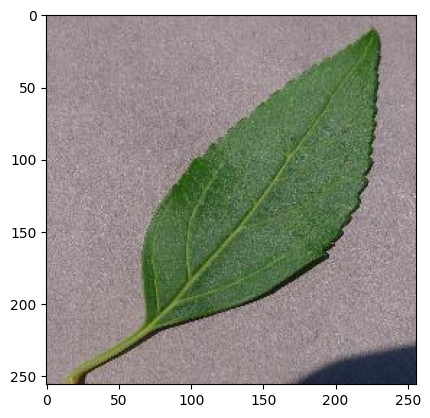

(20, 256, 256, 3)

--------------


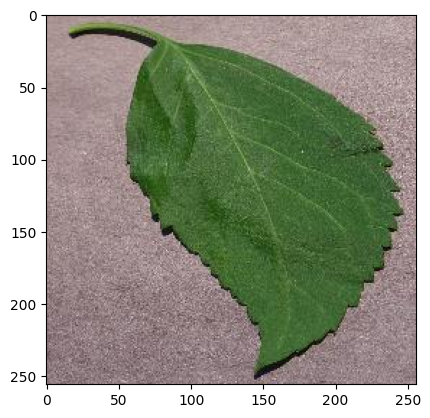

In [18]:
# test set
for _ in range(3):
    try:
        img, label = test_set.next()
    except:
        # for google collab functionality
        img, label = next(test_set)
    print(f'{img.shape}\n')
    plt.imshow(img[0])
    print('--------------')
    plt.show()

###  Observations
Augmented validation and test images have been standardized between 0 to 255 pixels. As you can see, the images are ugmented and are ready to be used for developing and training a CNN model.

### Save class indices

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v6/class_indices.pkl']

---

# Model Creation

---

### ML Model

* Import model packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model

* ### Model

In [21]:
def create_tf_model():
    """
    Creates a CNN model for binary classification of leaf images
    """
    model = Sequential()

    # Input layer: CONV1
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
        input_shape=image_shape,  # average image shape
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV2
    model.add(Conv2D(filters=12, kernel_size=(3, 3),
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CONV3
    model.add(Conv2D(filters=8, kernel_size=(3,3),
        activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy',])

    return model

## Model summary

In [23]:
summary = create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 12)      3468      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 8)         872       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)             

Plot model

In [24]:
try:
    plot_model(model, show_shapes=True, to_file=f'model_{version}.png')
except Exception as e:
    print(e)
    pass


name 'model' is not defined


Add early stopping
* Avoid overfitting

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=3)

In [26]:
# TODO remove before submit?
print(f'Train set object: {train_set}')
print(f"Number of samples in training set: {train_set.samples}")
print(f"Number of classes: {len(train_set.classes)}")
print(f"Batch size: {batch_size}")
print(f"Current steps calculation (classes/batch_size): {len(train_set.classes) // batch_size}")
print(f"Correct steps calculation (samples/batch_size): {train_set.samples // batch_size}")
print(f"Number of validation samples: {validation_set.samples}")
print(f"Validation steps per epoch: {validation_set.samples // batch_size}")

Train set object: <keras.preprocessing.image.DirectoryIterator object at 0x7f20870eaa90>
Number of samples in training set: 2944
Number of classes: 2944
Batch size: 20
Current steps calculation (classes/batch_size): 147
Correct steps calculation (samples/batch_size): 147
Number of validation samples: 420
Validation steps per epoch: 21


***

# Fit Model for training

### Save checkpoints

In [28]:
import os

# check if the full path exists
checkpoint_folder = f'/workspace/outputs/{version}/training_checkpoints'

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print('training checkpoints folder made')

# dynamically include the epoch in checkpoint file name
checkpoint_path = f"{checkpoint_folder}/cp-{{epoch:04d}}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback to save model weights per epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_freq='epoch',
                                                 monitor='accuracy',
                                                 save_best_only=True)


Brief untrained model evaluation

In [30]:
loss, acc = create_tf_model().evaluate(test_set, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))  # 2 decimal places

2024-11-01 13:20:29.489868: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


43/43 - 21s - loss: 0.6950 - accuracy: 0.4206
Untrained model, accuracy: 42.06%


Add CSV logger for history access in case of training runtime errors

In [31]:
history_csv_logger = CSVLogger('training.log', separator=',', append=False)

### Set epochs

In [32]:
EPOCHS = 25

In [33]:
try:
    model = create_tf_model()
    model.fit(train_set,
            epochs=EPOCHS,
            # TODO remove? steps_per_epoch=None, # None is equal to the number of samples in your dataset divided by the batch size
            steps_per_epoch = len(train_set.classes) // batch_size,
            validation_data=validation_set,
            # TODO remove? validation_steps=None,  #  validation will run until the validation_data dataset is exhausted
            callbacks=[early_stop, cp_callback, history_csv_logger],
            verbose=1,
            )
except Exception as e:
    print(e + '\n')

    # load latest weights
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)

    print('Model restored! Continuing...')
    # continue model training
    model.fit(train_set,
            epochs=EPOCHS,
            # TODO remove? steps_per_epoch=None, # None is equal to the number of samples in your dataset divided by the batch size
            steps_per_epoch = len(train_set.classes) // batch_size,
            validation_data=validation_set,
            # TODO remove? validation_steps=None,
            callbacks=[early_stop, cp_callback, history_csv_logger],
            verbose=1,
            )


Epoch 1/25
147/147 [==============================] - 248s 2s/step - loss: 0.4266 - accuracy: 0.7945 - val_loss: 0.5295 - val_accuracy: 0.8143

Epoch 00001: accuracy improved from -inf to 0.79446, saving model to /workspace/outputs/v6/training_checkpoints/cp-0001.ckpt
Epoch 2/25
147/147 [==============================] - 227s 2s/step - loss: 0.1792 - accuracy: 0.9350 - val_loss: 0.0325 - val_accuracy: 0.9929

Epoch 00002: accuracy improved from 0.79446 to 0.93502, saving model to /workspace/outputs/v6/training_checkpoints/cp-0002.ckpt
Epoch 3/25
147/147 [==============================] - 210s 1s/step - loss: 0.1221 - accuracy: 0.9593 - val_loss: 0.0236 - val_accuracy: 0.9929

Epoch 00003: accuracy improved from 0.93502 to 0.95930, saving model to /workspace/outputs/v6/training_checkpoints/cp-0003.ckpt
Epoch 4/25
147/147 [==============================] - 211s 1s/step - loss: 0.0701 - accuracy: 0.9778 - val_loss: 0.0111 - val_accuracy: 1.0000

Epoch 00004: accuracy improved from 0.95930

### Save model

In [34]:
try:
    model.save(f'outputs/{version}/cherry-tree-model.h5')
    print('model saved!')
except Exception as e:
    print(e)

model saved!


*** 

# Evaluate Model Performance 

In [35]:
# TODO remove?
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix, classification_report

# def extract_performance_from_history(model):
#     """
#     Extract and analyze performance metrics from model training history

#     Parameters:
#     - model: Trained Keras model
#     - history: Model training history object

#     Returns:
#     - Dictionary of performance metrics
#     """
#     # Extract metrics from history
#     history = model.history.history

#     performance_metrics = {
#         'training': {
#             'loss': history.get('loss', []),
#             'accuracy': history.get('accuracy', []),
#             'val_loss': history.get('val_loss', []),
#             'val_accuracy': history.get('val_accuracy', [])
#         }
#     }

#     # Calculate best epoch and corresponding metrics
#     best_train_accuracy = max(performance_metrics['training']['accuracy'])
#     best_val_accuracy = max(performance_metrics['training']['val_accuracy'])
#     best_train_loss = min(performance_metrics['training']['loss'])
#     best_val_loss = min(performance_metrics['training']['val_loss'])

#     performance_metrics['best_metrics'] = {
#         'best_train_accuracy': best_train_accuracy,
#         'best_val_accuracy': best_val_accuracy,
#         'best_train_loss': best_train_loss,
#         'best_val_loss': best_val_loss
#     }

#     return performance_metrics

# def plot_training_history(model):
#     """
#     Create plots for training and validation metrics

#     Parameters:
#     - history: Model training history object

#     Returns:
#     - Matplotlib figure with subplots
#     """
#     import matplotlib.pyplot as plt

#     history = model.history

#     plt.figure(figsize=(12, 4))

#     # Plot training & validation accuracy values
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='lower right')
#     plt.savefig(f'outputs/{version}/training_accuracy.png', bbox_inches='tight', dpi=600)

#     # Plot training & validation loss values
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Validation'], loc='upper right')

#     plt.tight_layout()
#     plt.savefig(f'outputs/{version}/training_history.png', bbox_inches='tight', dpi=600)
#     return plt

# def print_model_summary(model):
#     """
#     Print a detailed summary of the model architecture

#     Parameters:
#     - model: Keras model
#     """
#     # Capture model summary as a string
#     from io import StringIO
#     import sys

#     # Redirect stdout to capture model summary
#     old_stdout = sys.stdout
#     model_summary = StringIO()
#     sys.stdout = model_summary

#     model.summary()

#     # Restore stdout and get the summary
#     sys.stdout = old_stdout
#     summary_text = model_summary.getvalue()

#     print("Model Architecture Summary:")
#     print(summary_text)

# # Example usage:
# def comprehensive_model_analysis(model, train_set, validation_set, test_set, labels):
#     """
#     Provide comprehensive analysis of model performance

#     Parameters:
#     - model: Trained Keras model
#     - history: Model training history
#     - train_set, validation_set, test_set: Data generators
#     - labels: List of class labels
#     """
#     # 1. Print model summary
#     print(model.summary())

#     # 2. Extract performance metrics
#     performance_metrics = extract_performance_from_history(model)

#     # 3. Print performance metrics
#     print("\n--- Performance Metrics ---")
#     for metric, value in performance_metrics['best_metrics'].items():
#         print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

#     # 4. Plot training history
#     plt = plot_training_history(model)
#     plt.show()

#     # 5. TODO Generate confusion matrices?



In [36]:
# TODO remove?
# comprehensive_model_analysis(model, train_set, validation_set, test_set, labels)

### Plot model training loss and accuracy 

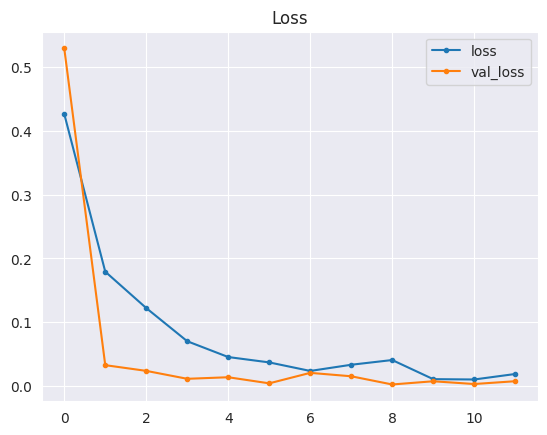

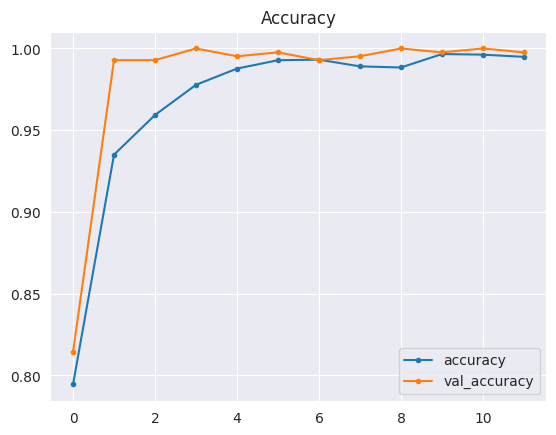

In [37]:
# TODO evaluate if this or above is better
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()


print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Evaluate and save

In [38]:
from keras.models import load_model

model = load_model(f'{file_path}/cherry-tree-model.h5')

In [39]:
try:
    eval1 = model.evaluate(test_set)
    evaluation_train = model.evaluate(train_set)
    evaluation_val = model.evaluate(validation_set)
except Exception as e:
    eval1 = model.evaluate(test_set)  # evaluate on test set only
    print(e)
    pass

21/21 [==============================] - 8s 370ms/step - loss: 0.0073 - accuracy: 0.9976


In [40]:
try:
    joblib.dump(value=eval1,filename=f"outputs/{version}/test-evaluation.pkl")
    joblib.dump(value=evaluation_train,filename=f"outputs/{version}/train-evaluation.pkl")
    joblib.dump(value=evaluation_val,filename=f"outputs/{version}/val-evaluation.pkl")
except Expection as e:
    print(e)
    print('-----')
    print('saving successful test eval')
    joblib.dump(value=eval1,filename=f"outputs/{version}/test-evaluation.pkl")


# Run Live Prediction 

Load image as PIL

Image shape: (256, 256), Image mode: RGB


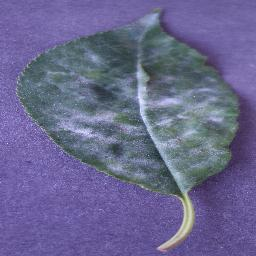

In [41]:
from tensorflow.keras.preprocessing import image
import random 
pointer = int(random.randrange(len(test_set)))  # random test_set image 
label = labels[1]  # select Uninfected or Parasitised # TODO make random 0 or 1

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert prediction image to array for prediction

In [42]:
pred_img = image.img_to_array(pil_image)
pred_img = np.expand_dims(pred_img, axis=0)/255
print(pred_img.shape)
pred_img

(1, 256, 256, 3)


array([[[[0.45490196, 0.40784314, 0.6509804 ],
         [0.45490196, 0.40784314, 0.6509804 ],
         [0.44313726, 0.39607844, 0.6392157 ],
         ...,
         [0.42352942, 0.38039216, 0.6156863 ],
         [0.42352942, 0.38039216, 0.6156863 ],
         [0.41568628, 0.37254903, 0.60784316]],

        [[0.4       , 0.3529412 , 0.59607846],
         [0.4117647 , 0.3647059 , 0.60784316],
         [0.42352942, 0.3764706 , 0.61960787],
         ...,
         [0.42352942, 0.38039216, 0.6156863 ],
         [0.41960785, 0.3764706 , 0.6117647 ],
         [0.4117647 , 0.36862746, 0.6039216 ]],

        [[0.41960785, 0.37254903, 0.6156863 ],
         [0.43529412, 0.3882353 , 0.6313726 ],
         [0.44705883, 0.4       , 0.6431373 ],
         ...,
         [0.43137255, 0.3882353 , 0.62352943],
         [0.42745098, 0.38431373, 0.61960787],
         [0.41960785, 0.3764706 , 0.6117647 ]],

        ...,

        [[0.43529412, 0.3764706 , 0.6313726 ],
         [0.43529412, 0.3764706 , 0.6313726 ]

Predict class probability on test image

In [43]:
pred_proba = model.predict(pred_img)[0, 0] # why 0 0?

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
  pred_proba = 1 - pred_proba

print(f'Prediction: {pred_class}\nConfidence: {pred_proba*100:.1f}%') # TODO do I want more decimal places?

Prediction: powdery_mildew
Confidence: 100.0%


*** 

### Push all notebook outputs to repo

In [44]:
try:
    !git add outputs/{version}
    !git commit -m f"Add " + {version} + " outputs for analysis"
    !git push origin main
except Exception as e:
    print(e)

[main 1a6539a] fAdd v6 outputs for analysis
 7 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/v6/class_distribution.png
 create mode 100644 outputs/v6/class_indices.pkl
 create mode 100644 outputs/v6/model_training_acc.png
 create mode 100644 outputs/v6/model_training_losses.png
 create mode 100644 outputs/v6/test-evaluation.pkl
 create mode 100644 outputs/v6/train-evaluation.pkl
 create mode 100644 outputs/v6/val-evaluation.pkl
Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 32 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (11/11), 175.21 KiB | 19.47 MiB/s, done.
Total 11 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/RaymondBrien/cherry-ml.git
To https://github.com/RaymondBrien/cherry-ML.git
   783bd96..1a6539a  main -> 